In [6]:
import time
import base64
from IPython.display import Image, display

from hypha_rpc.sync import connect_to_server,login
import os

import dotenv

dotenv.load_dotenv()  
ENV_FILE = dotenv.find_dotenv()  
if ENV_FILE:  
    dotenv.load_dotenv(ENV_FILE)  

server_url = "https://hypha.aicell.io"
try:
    reef_token = os.environ.get("REEF_WORKSPACE_TOKEN")
    squid_token = os.environ.get("SQUID_WORKSPACE_TOKEN")
except:
    token = await login({"server_url": server_url})
    reef_token = token
    squid_token = token

reef_server = connect_to_server({"server_url": server_url, "token": reef_token, "workspace": "reef-imaging", "ping_interval": None})
print(reef_server)
squid_server = connect_to_server({"server_url": server_url, "token": squid_token, "workspace": "squid-control", "ping_interval": None})
# Replace these with your actual service IDs
incubator_id = "incubator-control"
microscope_id = "microscope-control-squid-real-microscope-reef"
robotic_arm_id = "robotic-arm-control"

incubator = reef_server.get_service(incubator_id)
microscope = squid_server.get_service(microscope_id)
robotic_arm = reef_server.get_service(robotic_arm_id)

SyncHyphaServer({'_loop': <_UnixSelectorEventLoop running=True closed=False debug=False>, '_thread': <Thread(Thread-29 (_start_loop), started daemon 130916072486464)>, '_server': RemoteService({'id': '*/manager-roasted-walker-97813749:default', 'name': 'Default workspace management service', 'description': 'Services for managing workspace.', 'config': RemoteService({'require_context': True, 'visibility': 'public', 'server_id': 'roasted-walker-97813749', 'hypha_version': '0.20.47.post14', 'public_base_url': 'https://hypha.aicell.io', 'local_base_url': 'http://127.0.0.1:9520', 'auth0_client_id': 'paEagfNXPBVw8Ss80U5RAmAV4pjCPsD2', 'auth0_domain': 'amun-ai.eu.auth0.com', 'auth0_audience': 'https://amun-ai.eu.auth0.com/api/v2/', 'auth0_issuer': 'https://amun.ai/', 'login_service_url': 'https://hypha.aicell.io/public/services/hypha-login', 'workspace': 'reef-imaging', 'type': 'connection_info', 'manager_id': 'manager-roasted-walker-97813749', 'client_id': '4iuaaNBffSvuqek348aNGy', 'user': {

In [7]:
incubator.initialize()
while incubator.is_busy():
    time.sleep(1)

In [8]:
incubator.get_sample_from_slot_to_transfer_station(3)
while incubator.is_busy():
    time.sleep(1)

In [9]:
incubator.put_sample_from_transfer_station_to_slot(3)
while incubator.is_busy():
    time.sleep(1)

In [10]:
microscope.home_stage()

'The stage moved to home position in z, y, and x axis'

In [11]:
microscope.return_stage(context=None)

'The stage moved to the initial position'

## Every time you want to stop the robotic arm, you can run 'halt'

In [12]:
robotic_arm.connect()
robotic_arm.halt()


True

In [14]:
def load_plate_from_incubator_to_microscope(incubator_slot=3):
    """Load plate from incubator onto microscope."""
    incubator.get_sample_from_slot_to_transfer_station(incubator_slot)
    while incubator.is_busy():
        time.sleep(1)
    microscope.home_stage()
    print("Plate loaded onto microscope.")
    robotic_arm.connect()
    print("Robotic arm connected.")
    robotic_arm.grab_sample_from_incubator()
    print("Sample grabbed.")
    robotic_arm.transport_from_incubator_to_microscope1()
    print("Sample transported.")
    robotic_arm.put_sample_on_microscope1()
    print("Sample placed on microscope.")
    robotic_arm.disconnect()
    print("Robotic arm disconnected.")
    microscope.return_stage()
    print("Plate loaded onto microscope.")

In [15]:
load_plate_from_incubator_to_microscope(incubator_slot=3)

Plate loaded onto microscope.
Robotic arm connected.
Sample grabbed.
Sample transported.
Sample placed on microscope.
Robotic arm disconnected.
Plate loaded onto microscope.


Move the microscope's stage to well A1, and snap an image

In [16]:
microscope.navigate_to_well('A',1,wellplate_type="96")
image = microscope.snap(exposure_time=28,channel=0,intensity=20)
print(image)

https://hypha.aicell.io/squid-control/apps/data-store-real-microscope/get?id=3d18963e-e18d-41ed-96f2-ab641058b05f


In [18]:
microscope.auto_focus()

#### Note: the sample was from last week and the cells are dead, we will have a live cell sample today.

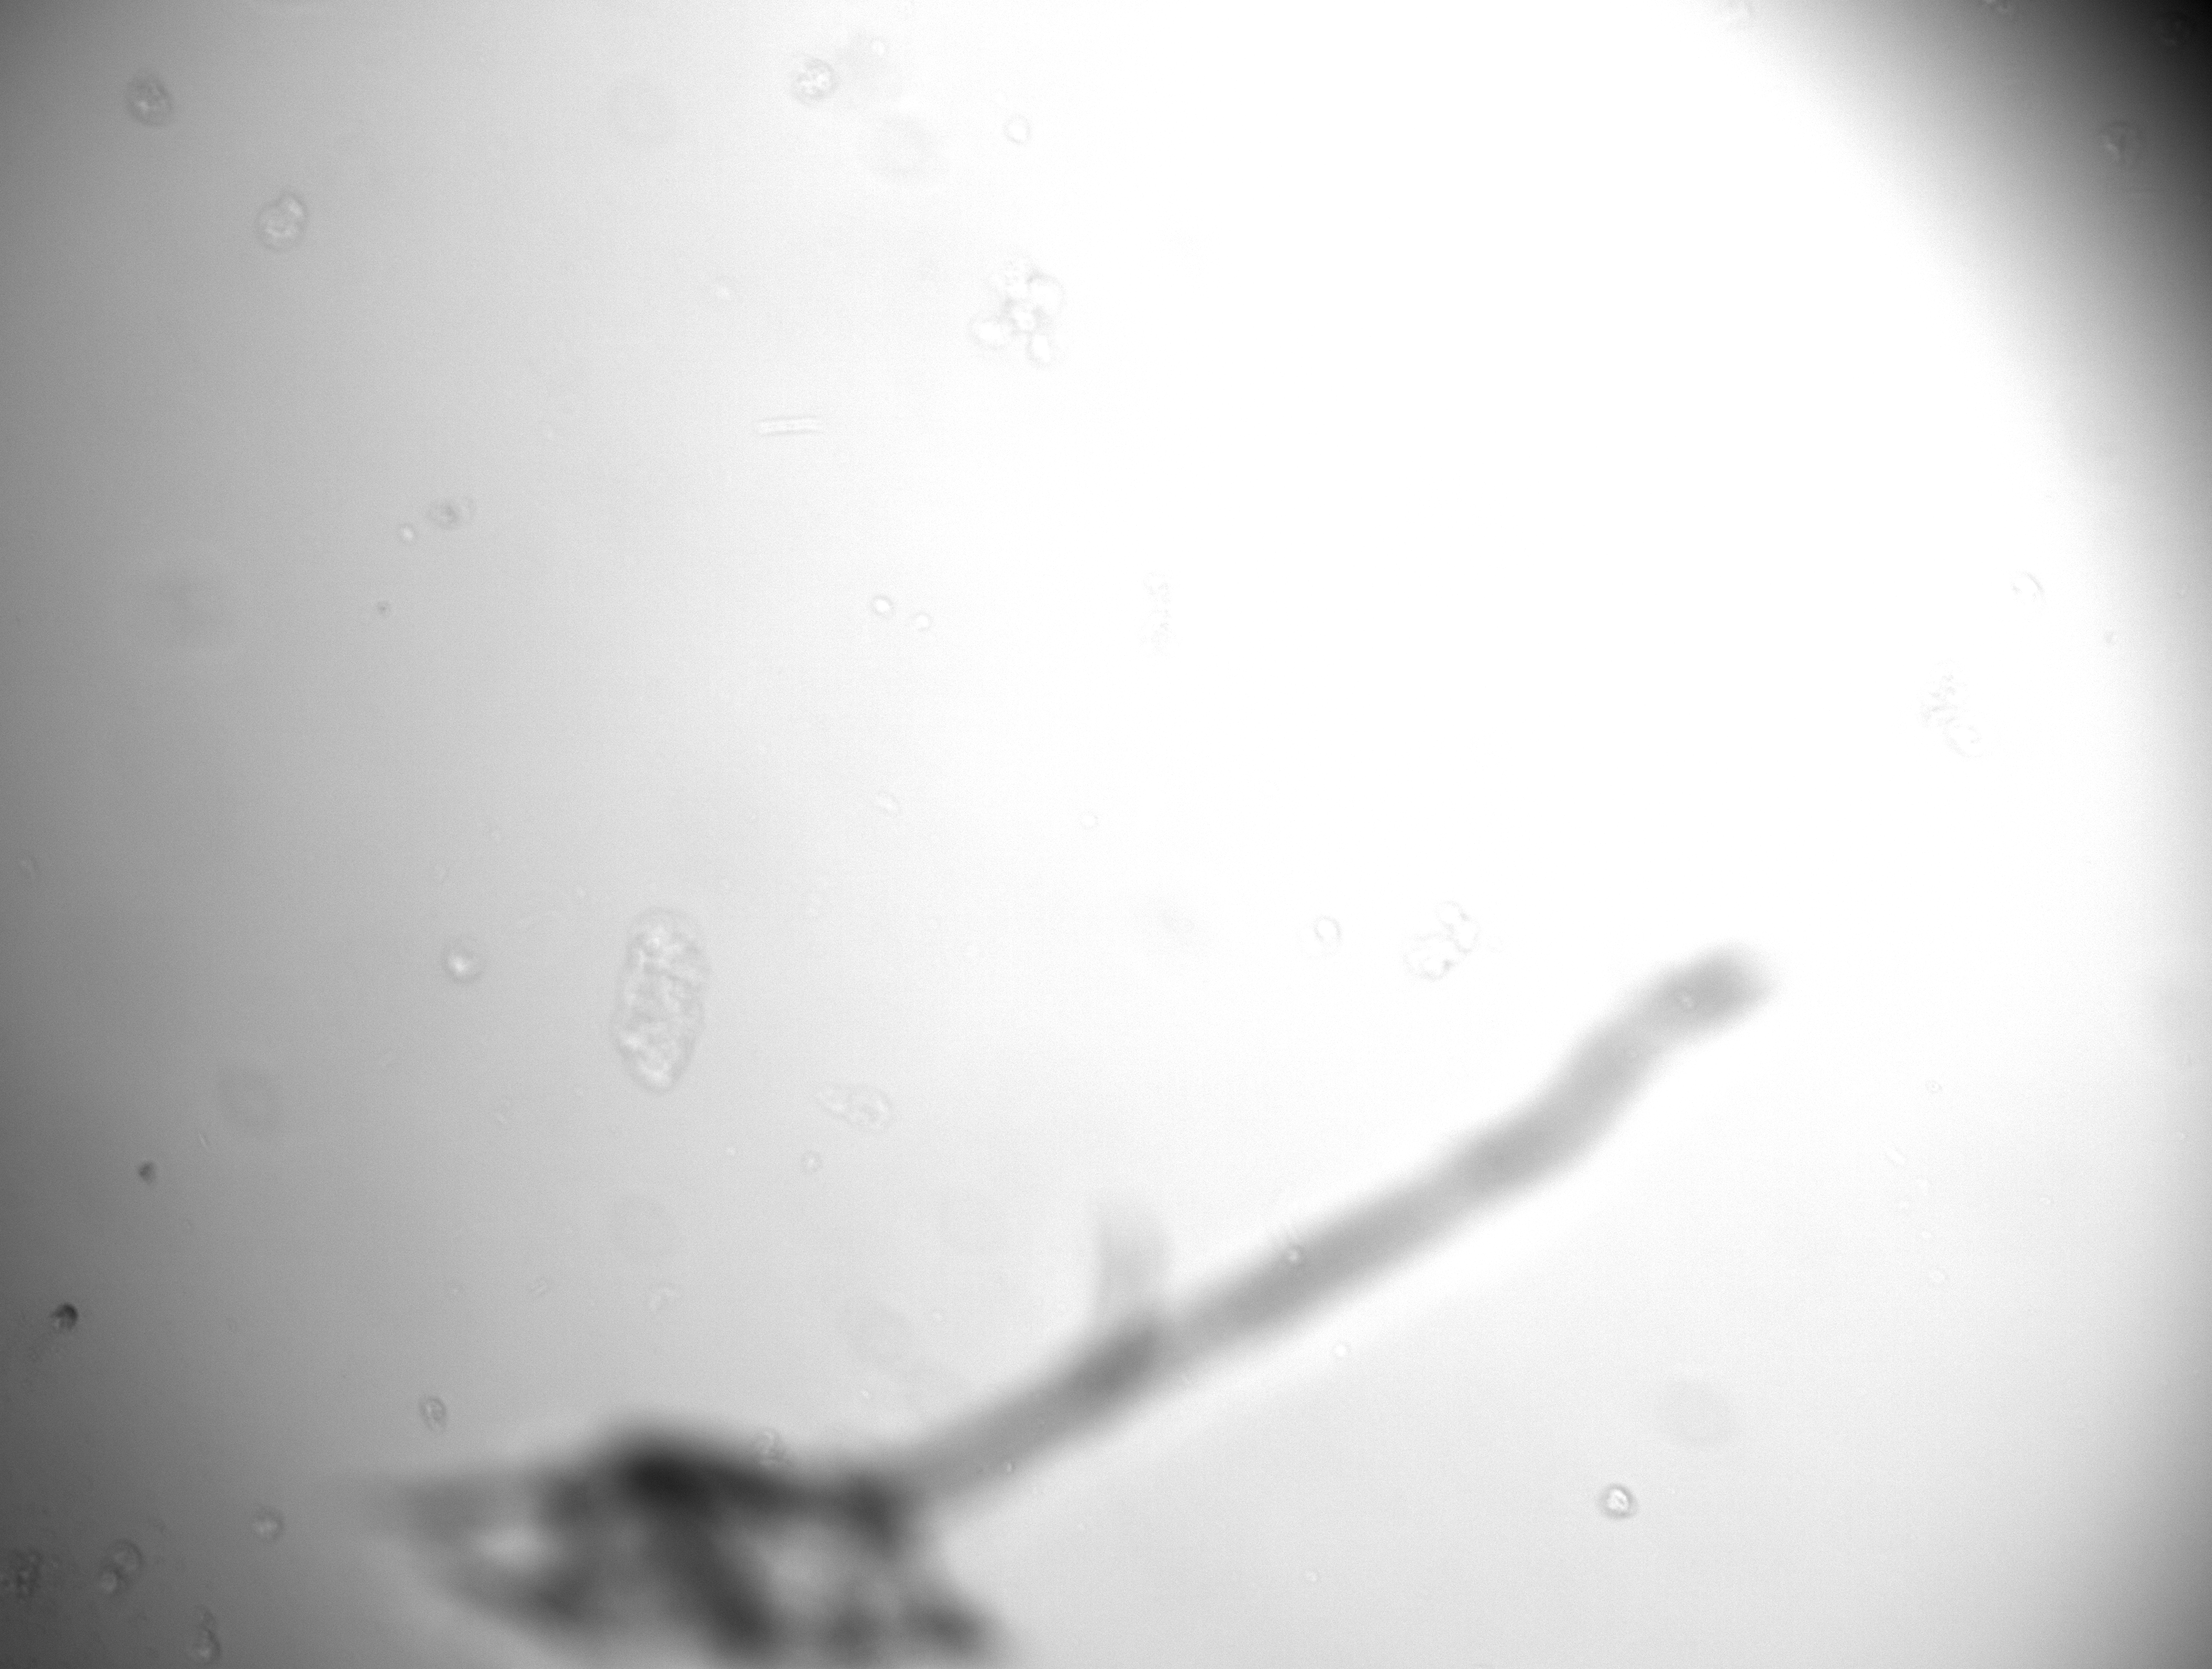

In [19]:
image_base64 = microscope.one_new_frame(exposure_time=28,channel=0,intensity=20)
img_data = base64.b64decode(image_base64)
display(Image(data=img_data))

### Put the sample back to incubator

In [24]:
def unload_plate_from_microscope(incubator_slot=3):

    robotic_arm.connect()
    # Move sample from microscope to incubator
    microscope.home_stage()
    print("microscope homed.")
    robotic_arm.grab_sample_from_microscope1()
    print("Sample grabbed from microscope.")
    robotic_arm.transport_from_microscope1_to_incubator()
    print("Sample moved to incubator.")
    robotic_arm.put_sample_on_incubator()
    print("Sample placed on incubator.")

    
    incubator.put_sample_from_transfer_station_to_slot(incubator_slot)
    while incubator.is_busy():
        time.sleep(1)
    print("Sample moved to incubator.")
    microscope.return_stage()

    robotic_arm.disconnect()

In [25]:
unload_plate_from_microscope()

microscope homed.
Sample grabbed from microscope.
Sample moved to incubator.
Sample placed on incubator.
Sample moved to incubator.
